In [1]:
# When something in the config is changed
%reload_kedro

2021-07-07 22:19:11,942 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2021-07-07 22:19:11,978 - root - INFO - ** Kedro project Foehn fire impact
2021-07-07 22:19:11,979 - root - INFO - Defined global variable `context`, `session` and `catalog`
2021-07-07 22:19:11,987 - root - INFO - Registered line magic `run_viz`


In [2]:
# Import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.lines import Line2D
import seaborn as sns
import plotly.express as px

plt.rcParams.update({'font.size': 20, 'figure.figsize': (16,9)})

import cartopy.crs as ccrs
import cartopy
from cartopy.io import shapereader
import geopandas

import sys
sys.path.append("../..")
from src.foehn_fire_impact.pipelines.fire_pipeline.utils import LV3_to_decimalWSG84

# Load data

In [3]:
df_fires = catalog.load("fire_data_with_foehn_and_control_variables")
df_stations = catalog.load("foehn_stations")

2021-07-07 22:19:13,009 - kedro.io.data_catalog - INFO - Loading data from `fire_data_with_foehn_and_control_variables` (CSVDataSet)...
2021-07-07 22:19:13,045 - kedro.io.data_catalog - INFO - Loading data from `foehn_stations` (CSVDataSet)...


In [4]:
# Load topographic data of Switzerland
df = catalog.load("topography_data")
df["lon"], df["lat"] = LV3_to_decimalWSG84(df["x"], df["y"])

2021-07-07 22:15:42,297 - kedro.io.data_catalog - INFO - Loading data from `topography_data` (CSVDataSet)...


In [5]:
# Drop stations and fire data for stations which are excluded from analysis
regions = context.params["regions"]
stations = regions["southern_switzerland"] + regions["northern_switzerland"]
df_stations = df_stations.loc[df_stations["abbreviation"].isin(stations), :]
df_fires = df_fires.loc[df_fires["abbreviation"].isin(stations), :]

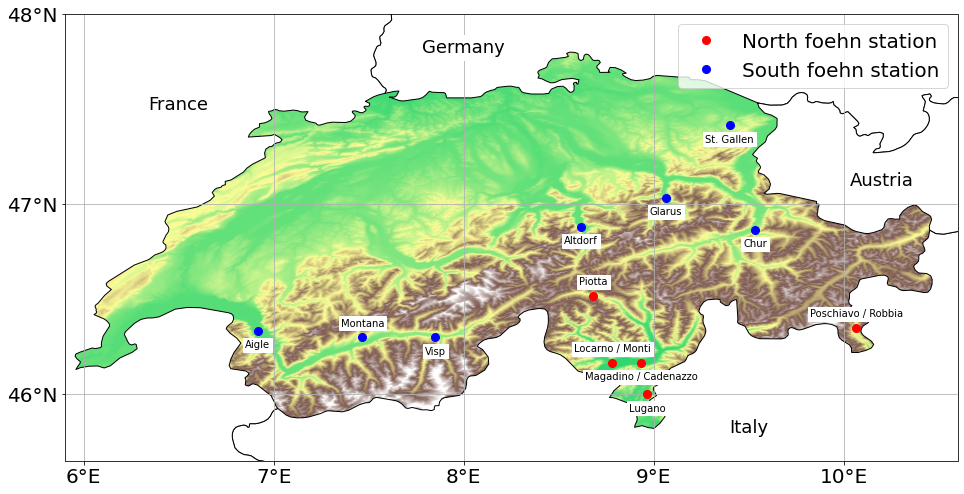

In [6]:
# Define projection and extent of plot
extent = [5.9, 10.6, 45.65, 48]
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent)

# Define looks of colormap
terrain = cm.get_cmap('terrain', 512)
newcmp = ListedColormap(terrain(np.linspace(0.3, 1.2, 256)))

# Plot topography
plt.scatter(df["lon"], df["lat"], c=df["z"], s=5, cmap=newcmp)

# Get country borders and plot them
shpfilename = shapereader.natural_earth(resolution="10m", category='cultural', name='admin_0_countries')
df_countries = geopandas.read_file(shpfilename)
for country in ["Germany", "Italy", "France", "Austria"]:
    if country == "Austria":
        poly = df_countries.loc[df_countries['ADMIN'] == country]['geometry'].values
    else:
        poly = df_countries.loc[df_countries['ADMIN'] == country]['geometry'].values[0]
    ax.add_geometries(poly, crs=ccrs.PlateCarree(), facecolor="white", edgecolor='black', zorder=1)
    
# Add country name labels
kwargs = {"textcoords": "offset points", "xytext": (0,0), "ha": "center", "color": "black", "backgroundcolor": "w", "fontsize": 18 }
plt.annotate("Italy", (9.5, 45.8), **kwargs)
plt.annotate("France", (6.5, 47.5), **kwargs)
plt.annotate("Germany", (8, 47.8), **kwargs)
plt.annotate("Austria", (10.2, 47.1), **kwargs)

# Make gridlines and axis labels    
ax.gridlines(xlocs=range(6,11), ylocs=range(46,48))
ax.set_xticks(range(6,11))
ax.set_xticklabels([f"{i}°E" for i in range(6,11)])
ax.set_yticks(range(46,49))
ax.set_yticklabels([f"{i}°N" for i in range(46,49)])

# Plot foehn stations
plt.plot(df_stations.loc[df_stations["abbreviation"].isin(regions["southern_switzerland"]), "longitude"], df_stations.loc[df_stations["abbreviation"].isin(regions["southern_switzerland"]), "latitude"], "ro", markersize=8)
plt.plot(df_stations.loc[df_stations["abbreviation"].isin(regions["northern_switzerland"]), "longitude"], df_stations.loc[df_stations["abbreviation"].isin(regions["northern_switzerland"]), "latitude"], "bo", markersize=8)

# Plot foehn station labels and move to non-overlapping position
for i, row in df_stations.iterrows():
    kwargs = {"text": row["name"], "xy": (row["longitude"], row["latitude"]), "textcoords": "offset points", "ha": "center", "color": "k", "backgroundcolor": "w", "fontsize": 10 }
    if row["abbreviation"] in ["MVE", "PIO", "SBE", "ROB", "AND", "OTL", "VAD"]: # Place label north
        plt.annotate(**kwargs, xytext=(0,11))
    elif row["abbreviation"] in ["CEV"]: # Place label west
        kwargs.update({"ha":"right"})
        plt.annotate(**kwargs, xytext=(-8,-3))
    else: # Place label south
        plt.annotate(**kwargs, xytext=(0,-17))
        
# Format legend
red_oval = Line2D([], [], markeredgecolor='red',color ="red", marker='o', linestyle='None', markersize=8, label="North foehn station")
blue_oval = Line2D([], [], markeredgecolor='blue',color ="blue", marker='o', linestyle='None', markersize=8, label="South foehn station")
plt.legend(handles=[red_oval, blue_oval], loc=1)

# Plot fire and foehn stations

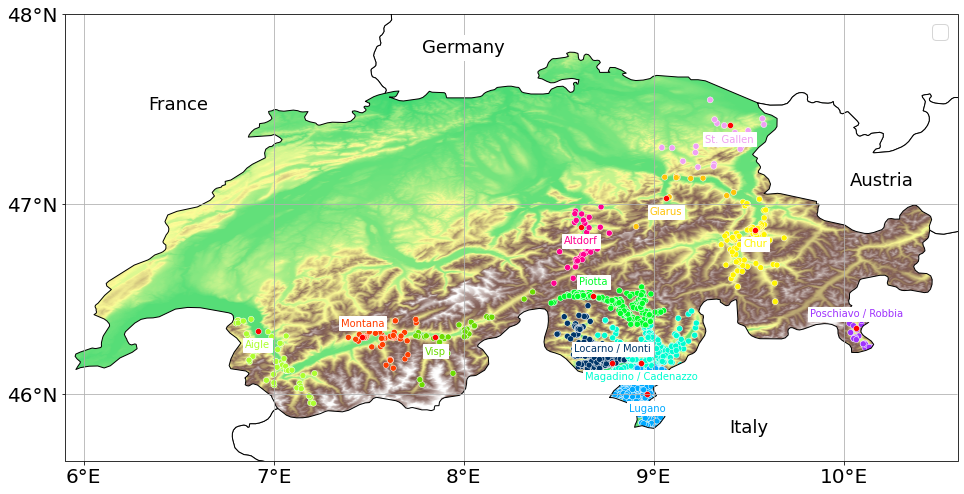

In [7]:
# Define projection and extent of plot
extent = [5.9, 10.6, 45.65, 48]
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent)

# Plot topography
plt.scatter(df["lon"], df["lat"], c=df["z"], s=5, cmap=newcmp)

# Get country borders and plot them
shpfilename = shapereader.natural_earth(resolution="10m", category='cultural', name='admin_0_countries')
df_countries = geopandas.read_file(shpfilename)
for country in ["Germany", "Italy", "France", "Austria"]:
    if country == "Austria":
        poly = df_countries.loc[df_countries['ADMIN'] == country]['geometry'].values
    else:
        poly = df_countries.loc[df_countries['ADMIN'] == country]['geometry'].values[0]
    ax.add_geometries(poly, crs=ccrs.PlateCarree(), facecolor="white", edgecolor='black', zorder=1)

# Add country name labels
kwargs = {"textcoords": "offset points", "xytext": (0,0), "ha": "center", "color": "black", "backgroundcolor": "w", "fontsize": 18 }
plt.annotate("Italy", (9.5, 45.8), **kwargs)
plt.annotate("France", (6.5, 47.5), **kwargs)
plt.annotate("Germany", (8, 47.8), **kwargs)
plt.annotate("Austria", (10.2, 47.1), **kwargs)

# Plot fires
unique = df_fires["abbreviation"].unique()
palette = dict(zip(unique, sns.color_palette(palette="gist_ncar", n_colors=len(unique))))
sns.scatterplot(x="longitude", y="latitude", data=df_fires, hue="abbreviation", palette=palette)

# Plot foehn station locations
sns.scatterplot(x=df_stations["longitude"], y=df_stations["latitude"], color="r")

# Plot foehn station labels and move to non-overlapping position
for i, row in df_stations.iterrows():
    kwargs = {"text": row["name"], "xy": (row["longitude"], row["latitude"]), "textcoords": "offset points", "ha": "center", "color": palette[row["abbreviation"]], "backgroundcolor": "w", "fontsize": 10 }
    if row["abbreviation"] in ["MVE", "PIO", "SBE", "ROB", "AND", "OTL", "VAD"]: # Place label north
        plt.annotate(**kwargs, xytext=(0,11))
    elif row["abbreviation"] in ["CEV"]: # Place label west
        kwargs.update({"ha":"right"})
        plt.annotate(**kwargs, xytext=(-8,-3))
    else: # Place label south
        plt.annotate(**kwargs, xytext=(0,-17))
    
# Make gridlines and axis labels    
ax.gridlines(xlocs=np.arange(6,11), ylocs=range(46,48))
ax.set_xticks(range(6,11))
ax.set_xticklabels([f"{i}°E" for i in range(6,11)])
ax.set_yticks(range(46,49))
ax.set_yticklabels([f"{i}°N" for i in range(46,49)])
plt.xlabel("")
plt.ylabel("")

# Remove legend
plt.legend("")

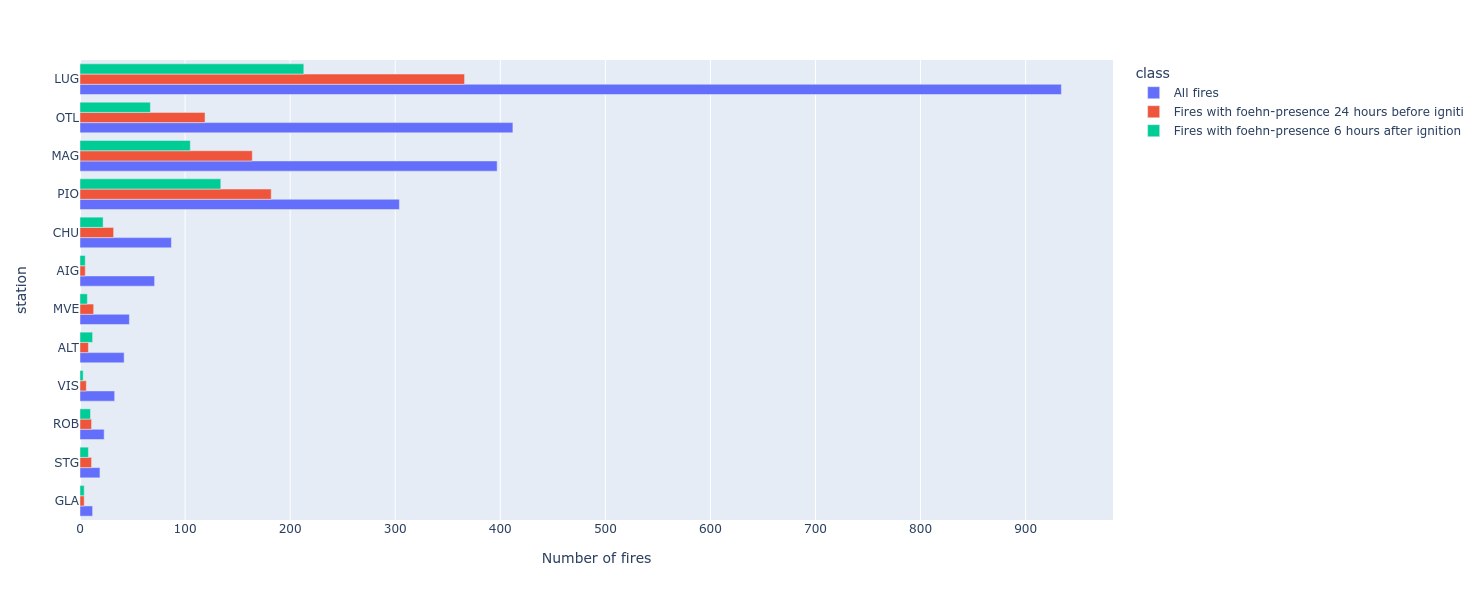

In [8]:
# Make a plot of fires influnced by foehn at each station
df_amount_fires = pd.DataFrame()
df_temp = df_fires.groupby("abbreviation", as_index=False).count().sort_values("total [ha]", ascending=True).reset_index()
df_temp["class"] = "All fires"
df_amount_fires = pd.concat([df_amount_fires, df_temp], axis=0, ignore_index=True)
df_temp = df_fires.loc[df_fires["foehn_minutes_24_hour_before"]>0, :].groupby("abbreviation", as_index=False).count().sort_values("total [ha]", ascending=True).reset_index()
df_temp["class"] = "Fires with foehn-presence 24 hours before ignition"
df_amount_fires = pd.concat([df_amount_fires, df_temp], axis=0, ignore_index=True)
df_temp = df_fires.loc[df_fires["foehn_minutes_during_6_hours_after_start_of_fire"]>0, :].groupby("abbreviation", as_index=False).count().sort_values("total [ha]", ascending=True).reset_index()
df_temp["class"] = "Fires with foehn-presence 6 hours after ignition"
df_amount_fires = pd.concat([df_amount_fires, df_temp], axis=0, ignore_index=True)

fig = px.bar(df_amount_fires, x="total [ha]", y=df_amount_fires["abbreviation"], color="class", orientation='h', barmode="group", height=600, labels={"abbreviation": "station", "total [ha]": "Number of fires"})
fig.show()

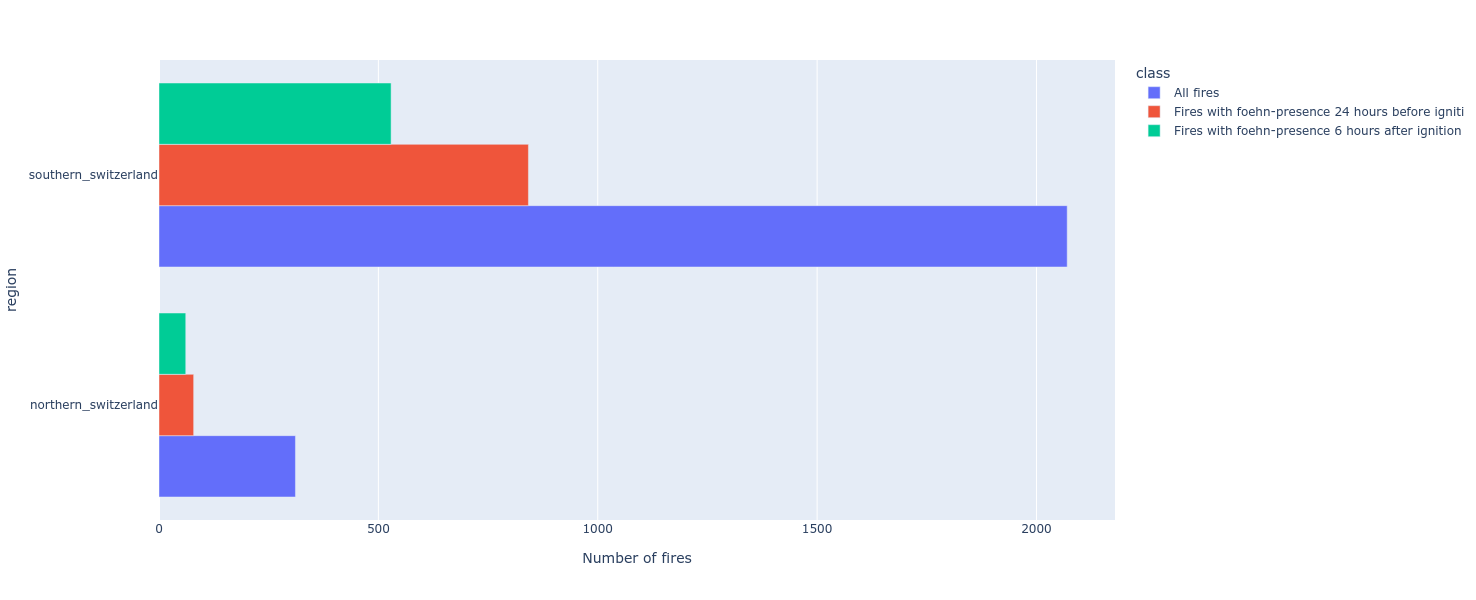

In [13]:
# Make a plot of fires influnced by foehn in each region
df_fires.loc[df_fires["abbreviation"].isin(regions["southern_switzerland"]), "region"] = "southern_switzerland"
df_fires.loc[df_fires["abbreviation"].isin(regions["northern_switzerland"]), "region"] = "northern_switzerland"

df_amount_fires = pd.DataFrame()
df_temp = df_fires.groupby("region", as_index=False).count()
df_temp["class"] = "All fires"
df_amount_fires = pd.concat([df_amount_fires, df_temp], axis=0, ignore_index=True)
df_temp = df_fires.loc[df_fires["foehn_minutes_24_hour_before"]>0, :].groupby("region", as_index=False).count()
df_temp["class"] = "Fires with foehn-presence 24 hours before ignition"
df_amount_fires = pd.concat([df_amount_fires, df_temp], axis=0, ignore_index=True)
df_temp = df_fires.loc[df_fires["foehn_minutes_during_6_hours_after_start_of_fire"]>0, :].groupby("region", as_index=False).count()
df_temp["class"] = "Fires with foehn-presence 6 hours after ignition"
df_amount_fires = pd.concat([df_amount_fires, df_temp], axis=0, ignore_index=True)

fig = px.bar(df_amount_fires, x="total [ha]", y="region", orientation='h', color="class", barmode="group", height=600, labels={"total [ha]": "Number of fires"})
fig.show()

# Plot ellipsoids around each stations

In [10]:
from functools import partial
import pyproj
from shapely.ops import transform
from shapely.geometry import Point
import matplotlib.lines as mlines
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  # Due to older pyproj library

def geodesic_point_expansion(lat, lon, km):
    """
    Expand a point to a circle
    @param lat, lon: Coordinates
    @param km: Size of circle in km
    @returns: List of tuples with coords
    """
    # Azimuthal equidistant projection
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lat=lat, lon=lon)),
        pyproj.Proj('+proj=longlat +datum=WGS84'))
    buf = Point(0, 0).buffer(km * 1000)  # distance in metres
    return transform(project, buf).exterior.coords[:]

2021-07-07 22:16:25,269 - kedro.io.data_catalog - INFO - Loading data from `fire_data_cleansed` (CSVDataSet)...


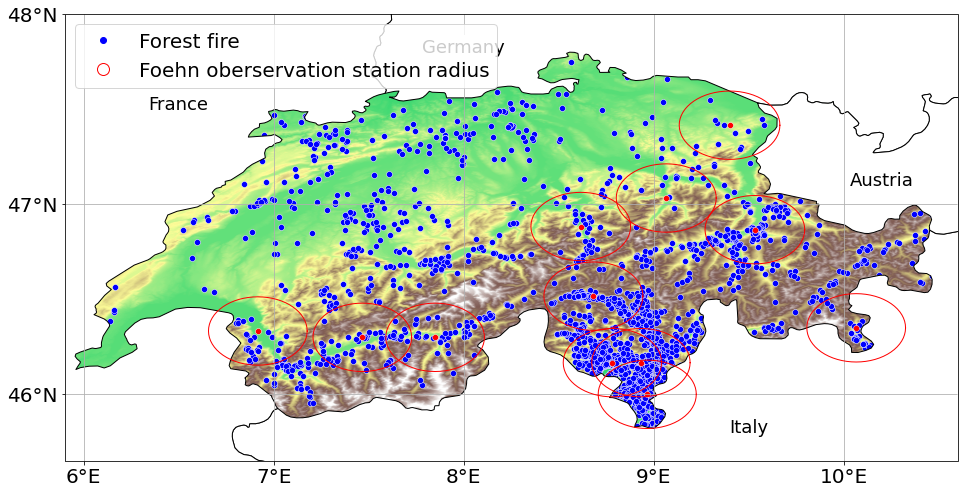

In [11]:
# Define projection and extent of plot
extent = [5.9, 10.6, 45.65, 48]
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent)

# Plot topography
plt.scatter(df["lon"], df["lat"], c=df["z"], s=5, cmap=newcmp)

# Get country borders and plot them
shpfilename = shapereader.natural_earth(resolution="10m", category='cultural', name='admin_0_countries')
df_countries = geopandas.read_file(shpfilename)
for country in ["Germany", "Italy", "France", "Austria"]:
    if country == "Austria":
        poly = df_countries.loc[df_countries['ADMIN'] == country]['geometry'].values
    else:
        poly = df_countries.loc[df_countries['ADMIN'] == country]['geometry'].values[0]
    ax.add_geometries(poly, crs=ccrs.PlateCarree(), facecolor="white", edgecolor='black', zorder=1)

# Add country name labels
kwargs = {"textcoords": "offset points", "xytext": (0,0), "ha": "center", "color": "black", "backgroundcolor": "w", "fontsize": 18 }
plt.annotate("Italy", (9.5, 45.8), **kwargs)
plt.annotate("France", (6.5, 47.5), **kwargs)
plt.annotate("Germany", (8, 47.8), **kwargs)
plt.annotate("Austria", (10.2, 47.1), **kwargs)

# Plot fires
sns.scatterplot(x="longitude", y="latitude", data=catalog.load("fire_data_cleansed"), facecolor="b")

# Plot foehn station locations
sns.scatterplot(x=df_stations["longitude"], y=df_stations["latitude"], color="r")

# Plot ellipsoids for each station
for i, row in df_stations.iterrows():
    ellipse = geodesic_point_expansion(df_stations.loc[i, "latitude"], df_stations.loc[i, "longitude"], 20)
    x= [point[0] for point in ellipse]
    y= [point[1] for point in ellipse]
    plt.plot(x, y, "-", color="r", linewidth=1)
    
# Make gridlines and axis labels    
ax.gridlines(xlocs=np.arange(6,11), ylocs=range(46,48))
ax.set_xticks(range(6,11))
ax.set_xticklabels([f"{i}°E" for i in range(6,11)])
ax.set_yticks(range(46,49))
ax.set_yticklabels([f"{i}°N" for i in range(46,49)])
plt.xlabel("")
plt.ylabel("")

# Format legend
blue_cross = mlines.Line2D([], [], color='blue', marker='o', linestyle='None',
                          markersize=6, label='Forest fire')
red_oval = mlines.Line2D([], [], markeredgecolor='red',color ="white", marker='o', linestyle='None',
                          markersize=12, label="Foehn oberservation station radius")
plt.legend(handles=[blue_cross, red_oval], loc=2)